In [28]:
# Módulos
import re
from typing import List, Set, Union
from networkx import DiGraph, draw, set_node_attributes, draw_networkx_edge_labels, planar_layout, get_edge_attributes, to_pandas_adjacency
import pandas as pd

In [29]:
# Entradas e constantes
entrada = (
    "E -> T + E\n"
    "E -> T\n"
    "T -> n"
)
entrada = (
    "S -> A + B\n"
    "A -> a\n"
    "B -> b"
)
variavel_inicial = "E"
variavel_inicial = "S"

In [30]:
# Expressões regulares
def obter_variaveis(producoes: str) -> Set[str]:
    return set(re.findall("[A-Z]", producoes, re.MULTILINE))

def obter_terminais(producoes: str) -> List[str]:
    return [*sorted([*set(re.findall("[^A-Z→\n]", producoes, re.MULTILINE))]), "$"]

def obter_simbolos_pendentes(producoes: str) -> Set[str]:
    return set(re.findall("·(.)", producoes, re.MULTILINE))

def obter_variaveis_pendentes(producoes: str) -> Set[str]:
    return set(re.findall("·([A-Z])", producoes, re.MULTILINE))

def obter_producoes_by_variavel(producoes: str, variavel: str) -> Set[str]:
    return set(re.findall(f"^{re.escape(variavel)}→.+$", producoes, re.MULTILINE))

def obter_producoes_by_simbolo(producoes: str, simbolo: str) -> Set[str]:
    return set(re.findall(f"^.+→.*·{re.escape(simbolo)}.*$", producoes, re.MULTILINE))

In [31]:
# Obtém recursivamente o estado inicial
def obter_estado_inicial_auxiliar (producoes: str, variavel: str, variaveis_analisadas: Set[str]) -> str: 
    novas_variaveis_analisadas = set([*variaveis_analisadas, variavel])
    novas_producoes = re.sub(f"({re.escape(variavel)}→)(.+)", r"\1·\2", producoes, flags=re.MULTILINE)
    variaveis_pendentes = obter_variaveis_pendentes(novas_producoes) - novas_variaveis_analisadas
    if variaveis_pendentes: 
        return obter_estado_inicial_auxiliar(novas_producoes, next(iter(variaveis_pendentes)), novas_variaveis_analisadas)
    else:
        return novas_producoes

def obter_estado_inicial (producoes: str, variavel: str) -> str:
    return obter_estado_inicial_auxiliar(producoes, variavel, set([]))

In [32]:
# Simula a leitura de uma variável chegando num novo estado
def fechamento_auxiliar (estado_inicial: str, estado_atual: str, variaveis_analisadas: Set[str]) -> str:
    variaveis_pendentes_fechamentos = obter_variaveis_pendentes(estado_atual) - variaveis_analisadas
    if  variaveis_pendentes_fechamentos:
        variavel = next(iter(variaveis_pendentes_fechamentos))
        novas_variaveis_analisadas = set([*variaveis_analisadas, variavel])
        producoes_fechamentos = "\n".join(obter_producoes_by_variavel(estado_inicial, variavel))
        novo_estado_atual = f"{estado_atual}\n{producoes_fechamentos}"
        return fechamento_auxiliar(estado_inicial, novo_estado_atual, novas_variaveis_analisadas)
    else:
        return estado_atual

def fechamento (estado_inicial: str, estado_atual: str) -> str:
    return fechamento_auxiliar(estado_inicial, estado_atual, set([]))

def simular_leitura (estado_inicial: str, estado_atual: str, variavel: str):
    producoes_afetadas = obter_producoes_by_simbolo(estado_atual, variavel)
    producoes_afetadas_atualizadas = "\n".join([re.sub(f"·{re.escape(variavel)}", f"{variavel}·", producao, flags=re.MULTILINE) for producao in producoes_afetadas])
    return fechamento(estado_inicial, producoes_afetadas_atualizadas)

In [33]:
# Executa a busca em largura para mapear todos os estados
def percorrer_estados_auxiliar(estado_inicial: str, estado_atual: str, resultado: DiGraph):
    simbolos_pendentes = obter_simbolos_pendentes(estado_atual)
    for simbolo in simbolos_pendentes:
        proximo_estado = simular_leitura(estado_inicial, estado_atual, simbolo)
        if proximo_estado not in resultado.nodes:
            is_aceitacao = True if "'" in proximo_estado else False
            atributos = {}
            reducao = re.findall("(.)·$", proximo_estado, re.MULTILINE)
            if reducao and not is_aceitacao:
                atributos["is_reducao"] = True
                atributos["reducao"] = ",".join(reducao)
            else:
                atributos["is_reducao"] = False
                atributos["reducao"] = None
            resultado.add_node(proximo_estado, is_aceitacao=is_aceitacao, indice_reducao=None, **atributos)
            resultado.add_edge(estado_atual, proximo_estado, simbolo=simbolo)
            percorrer_estados_auxiliar(estado_inicial, proximo_estado, resultado)

def percorrer_estados(entrada: str, variavel_inicial: str):
    estado_inicial = obter_estado_inicial(entrada, variavel_inicial)
    resultado = DiGraph()
    resultado.add_node(estado_inicial, is_aceitacao=False, is_reducao=False, indice_reducao=None, reducao=None)
    percorrer_estados_auxiliar(estado_inicial, estado_inicial, resultado)
    indices = {estado: indice for indice, estado in enumerate(list(resultado.nodes))}
    indices_reducoes = {estado: indice for indice, estado in enumerate([item for item in resultado.nodes if resultado.nodes[item]["is_reducao"]])}
    set_node_attributes(resultado, indices, "indice")
    set_node_attributes(resultado, indices_reducoes, "indice_reducao")
    return resultado

In [34]:
# Tratamento da entrada
nova_variavel_inicial =  f"{variavel_inicial}'"
entrada_normalizada = entrada.replace(" ", "").replace("->","→")
entrada_parseada = f"{nova_variavel_inicial}→{variavel_inicial}\n{entrada_normalizada}"
variaveis = obter_variaveis(entrada_normalizada)
terminais = obter_terminais(entrada_normalizada)

["S'→·S\nS→·A+B\nA→·a\nB→b", 'A→a·', 'S→A·+B', 'S→A+·B\nB→b', 'S→A+B·', "S'→S·"]


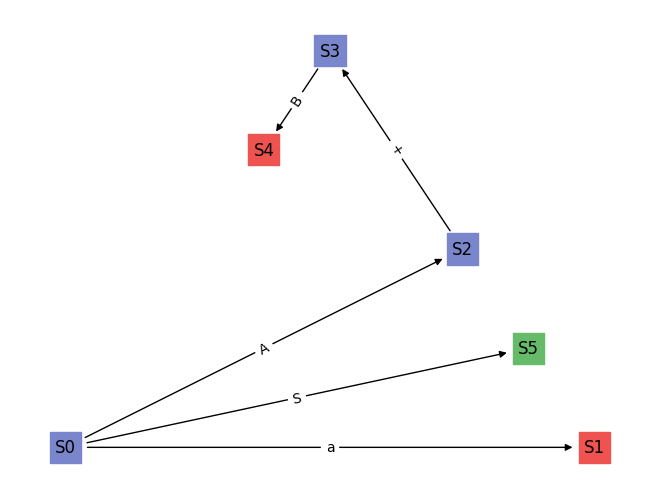

In [35]:
resultado = percorrer_estados(entrada_parseada, nova_variavel_inicial)
posicao = planar_layout(resultado)
rotulos = {vertice: f"S{resultado.nodes[vertice]['indice']}" for vertice in resultado.nodes}
cores = ["#66bb6a" if resultado.nodes[vertice]["is_aceitacao"] else "#ef5350" if resultado.nodes[vertice]["is_reducao"] else "#7986cb" for vertice in resultado.nodes]
draw(resultado, posicao, labels=rotulos, node_color=cores, node_size=500, node_shape="s", with_labels=True)
draw_networkx_edge_labels(resultado, posicao, edge_labels=get_edge_attributes(resultado, "simbolo"))
print(resultado.nodes)

In [36]:
legenda = pd.DataFrame.from_records([{"estado": item, **resultado.nodes[item]} for item in resultado.nodes], index="indice").rename_axis(None).set_axis(["Estado", "Aceitação?", "Redução?", " N.º Redução", "Redução"], axis=1)
legenda

,Estado,Aceitação?,Redução?,N.º Redução,Redução
0,S'→·S\nS→·A+B\nA→·a\nB→b,False,False,NaN,None
1,A→a·,False,True,0.0,a
2,S→A·+B,False,False,NaN,None
3,S→A+·B\nB→b,False,False,NaN,None
4,S→A+B·,False,True,1.0,B
5,S'→S·,True,False,NaN,None


In [37]:
tabela = [{"indice": item, **{terminal:[] for terminal in terminais}, **{variavel:[] for variavel in variaveis}} for item in [resultado.nodes[item]["indice"] for item in resultado.nodes]]
for estado in [resultado.nodes[item]["indice"] for item in resultado.nodes if resultado.nodes[item]["is_aceitacao"]]:
    tabela[estado]["$"].append("ACC")
for estado, linha in enumerate(tabela):
    vertice = next(item for item in resultado.nodes if resultado.nodes[item]["indice"] == estado)
    simbolos_destinos = [(atributos["simbolo"], resultado.nodes[destino]["indice"]) for origem, destino, atributos in resultado.edges(data=True) if origem == vertice]
    for simbolo, destino in simbolos_destinos:
        if simbolo.isupper():
            tabela[estado][simbolo].append(f"{destino}")
        else:
            tabela[estado][simbolo].append(f"S{destino}")
reducoes_indices = [(resultado.nodes[item]["indice"], resultado.nodes[item]["indice_reducao"]) for item in resultado.nodes if resultado.nodes[item]["is_reducao"]]
for indice, indice_reducao in reducoes_indices:
    for terminal in terminais:
        tabela[indice][terminal].append(f"R{indice_reducao}")
pd.DataFrame.from_records(tabela, index="indice").rename_axis(None)

,+,a,b,$,B,A,S
0,[],[S1],[],[],[],[2],[5]
1,[R0],[R0],[R0],[R0],[],[],[]
2,[S3],[],[],[],[],[],[]
3,[],[],[],[],[4],[],[]
4,[R1],[R1],[R1],[R1],[],[],[]
5,[],[],[],[ACC],[],[],[]
